In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

In [36]:
df = pd.read_csv('../data/SBER_250914_250915.csv', sep=';')

df["date_str"]=df["<DATE>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["time_str"]=df["<TIME>"].apply(lambda x: str(x).zfill(6)).astype(str)
df["datetime_str"]=df["date_str"]+df["time_str"]
df["time_utc"]= pd.to_datetime(df["datetime_str"], format='%y%m%d%H%M%S', utc=True)
df = df.set_index("time_utc")
df.drop(["date_str", "time_str", "datetime_str", "<DATE>", "<TIME>"], axis=1, inplace=True)
df.rename(columns={"<OPEN>": "open", "<HIGH>": "high", "<LOW>": "low", "<CLOSE>": "close", "<VOL>": "volume"}, inplace=True)

df = df.tail(200)

In [37]:
# make stationary
diff_close = np.diff(df["close"], n=1)

ADF_result = adfuller(diff_close)
print(f'ADF Statistic: {ADF_result[0]}')
print(f'p-value: {ADF_result[1]}')


ADF Statistic: -11.364641522468768
p-value: 9.291103856028411e-21


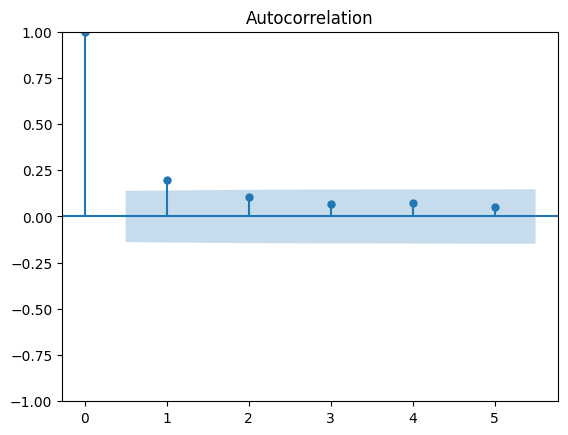

In [38]:
plot_acf(diff_close, lags=5);

In [39]:
df_diff = pd.DataFrame({'diff_close': diff_close})
train = df_diff[:int(0.9*len(df_diff))]
test = df_diff[int(0.9*len(df_diff)):]

print(len(train), len(test))#df_diff

179 20


In [40]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:

    total_len = train_len + horizon

    if method == 'mean':
        pred_mean = []

        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))

        return pred_mean

    elif method == 'last':
        pred_last_value = []

        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))

        return pred_last_value

    elif method == 'MA':
        pred_MA = []

        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(0,0,1))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_MA.extend(oos_pred)

        return pred_MA

In [41]:
pred_df = test.copy()

TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_MA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'MA')

pred_df['pred_mean'] = pred_mean
pred_df['pred_last_value'] = pred_last_value
pred_df['pred_MA'] = pred_MA

pred_df.head()

,diff_close,pred_mean,pred_last_value,pred_MA
179,0.02,-0.000670,-0.04,-0.009448
180,0.06,-0.000556,0.02,0.005267
181,-0.16,-0.000221,0.06,0.009881
182,0.04,-0.001099,-0.16,-0.029805
183,0.04,-0.000874,0.04,0.011504


In [42]:
from sklearn.metrics import mean_squared_error

mse_mean = mean_squared_error(pred_df['diff_close'], pred_df['pred_mean'])
mse_last = mean_squared_error(pred_df['diff_close'], pred_df['pred_last_value'])
mse_MA = mean_squared_error(pred_df['diff_close'], pred_df['pred_MA'])

print(mse_mean, mse_last, mse_MA)

0.006746820765259722 0.013484999999997752 0.0069143893319399225


In [43]:
df['pred_close'] = pd.Series()
df['pred_close'][180:] = df['close'].iloc[180] + pred_df['pred_MA'].cumsum()

C:\Users\A\AppData\Local\Temp\ipykernel_528480\2852034848.py:2: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['pred_close'][180:] = df['close'].iloc[180] + pred_df['pred_MA'].cumsum()
C:\Users\A\AppData\Local\Temp\ipykernel_528480\2852034

In [44]:
#df = df.tail(100)

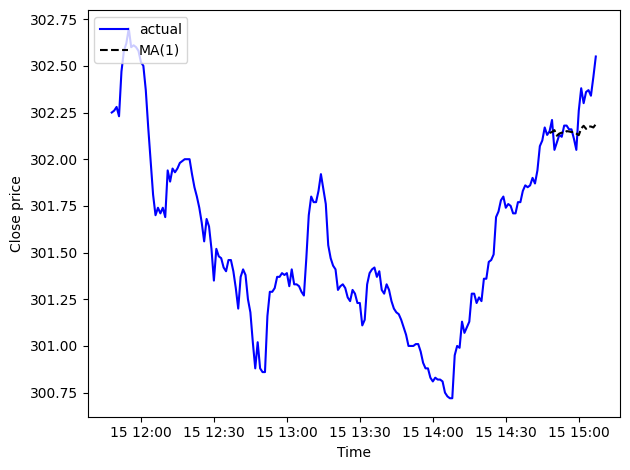

In [45]:
fig, ax = plt.subplots()

ax.plot(df['close'], 'b-', label='actual')
ax.plot(df['pred_close'], 'k--', label='MA(1)')

ax.legend(loc=2)
ax.set_xlabel('Time')
ax.set_ylabel('Close price')

#ax.axvspan(180, 200, color='#808080', alpha=0.2)
#ax.set_xlim(50, 200)

plt.tight_layout()


In [46]:
from sklearn.metrics import mean_absolute_error

mae_MA_undiff = mean_absolute_error(df['close'].iloc[180:], df['pred_close'].iloc[180:])

print(mae_MA_undiff)

0.10609593381073239
